# Pipeline A: 
## Step 1) Normalize Data

Import all the nessasary packages needed for Pipeline A & read in the data. Lastly make sure the data looks ok.

In [16]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import zscore, skew
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from itertools import chain
import xgboost
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 500)

In [17]:
#Read In The Data Needed For Pipeline B
conti = pd.read_csv('continuous_df.csv')
# cate = pd.read_csv('categorical_df.csv')

In [18]:
conti.head(1)

,Unnamed: 0,I1,C7_imputed,C1,C4,C3_imputed,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime
0,0,AATI,51.345,122.0,0.029074,3.43,27.061702,0.908876,0.091124,169.0,0.359574,0.640426,0.05425,0.194969,0.367925,0.437107,51562052.0,9.957905e-07,0.794422,0.205578,3.864345,11.111111


Check Normality of fields. Create histograms to view values to check normality. Also use Shapiro to test the normality of the values.

In [19]:
def check_normal_by_hist(df, col):
    
    df[col].hist()
    plt.title(col)
    plt.show()
    
def check_normal_by_shapiro(df, col):
    
    return shapiro(df[col].values)

def check_skew(df, col):
    return skew(df[col])

def bad_skew(df, col_list):
    bad_ones = []
    skews = []
    for i in col_list:
        skw = skew(df[i])
        if (skw > 0.5) or (skw < -0.5):
            bad_ones.append(i)
            skews.append(skw)
    return bad_ones, skews

Drop Unnamed columns that came in via the csv read

In [20]:
conti.drop(columns = ['Unnamed: 0'], inplace = True)

In [21]:
bad_fields, bad_skew = bad_skew(conti, conti.columns.tolist()[1:])

Code for normalization techniques to try to normalize our data

In [22]:
def normalize_log(col_vals):
    return np.log(col_vals + min(col_vals))

def normalize_sqrt(col_vals):
    if min(col_vals) < 0:
        print('Can\'t sqrt with negative values')
        return
    return np.sqrt(col_vals)

def normalize_recip_sqrt(col_vals):
    if min(col_vals) < 0:
        print('Can\'t sqrt with negative values')
        return
    return 1/np.sqrt(col_vals)

def normalize_sigmoid(col_vals):
    return [1/(1+np.e**(-i)) for i in col_vals]

def normalize_div(col_vals):
    return 1/col_vals

def normalize_log_div(col_vals):
    return 1/np.log(col_vals + min(col_vals))

def normalize_shift_left(col_vals):
    return col_vals - len(col_vals)

def normalize_shift_right(col_vals):
    return col_vals + len(col_vals)

def normalize_by_power(col_vals):
    return [i**2 for i in col_vals]

def normalize_by_e(col_vals):
    return [np.e **(i + min(col_vals)) for i in col_vals]

def normalize_data(df, col, normalize_function = None):
    '''
    Given a dataframe, column, and type of normalization, attempt to make the field normal.
    
    params:
    df - dataframe
    col - string - column to normalize
    normalize_function - function - type of normalization to perform. If blank then all will be performed and compared.
        options are functions above
        
    '''
    
    if normalize_function is not None:
        try:
            new_vals = normalize_function(df[col].values)
            p_val = shapiro(new_vals)[1]
            valid = 'Normal' if p_val > 0.05 else 'Non-Normal'
            print('Shapiro Test says given function made the data ' + valid +' with a p-value of ' + str(p_val))
            if p_val > 0.05:
                plt.hist(new_vals)
                return True
            else:
                return False
        except Exception as e:
            print(e)

Create Histograms of Fields

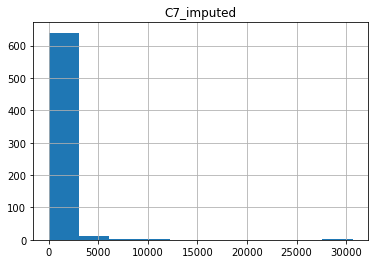

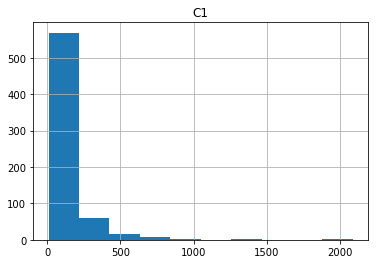

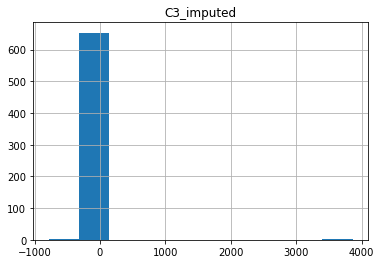

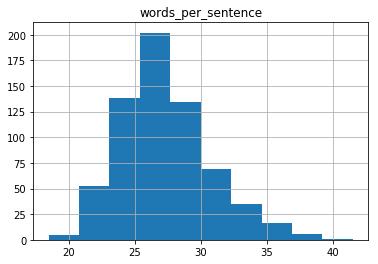

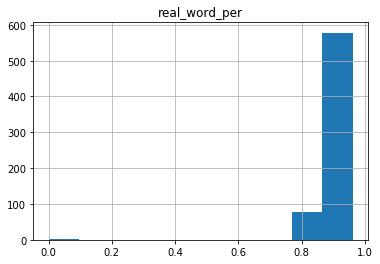

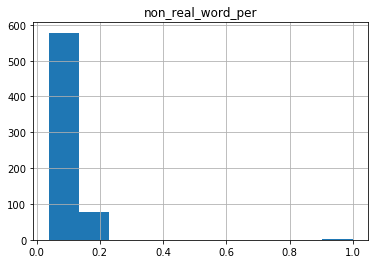

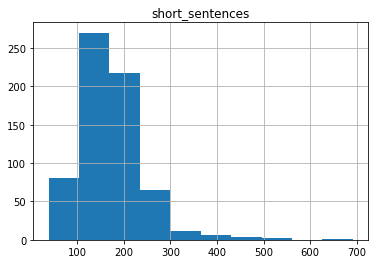

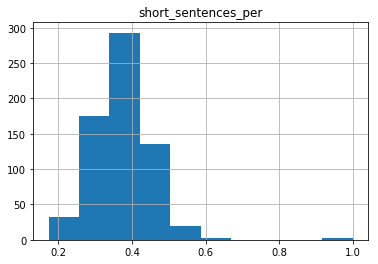

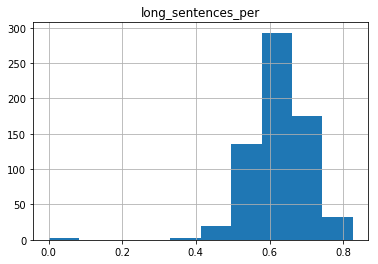

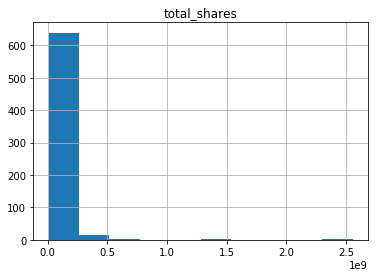

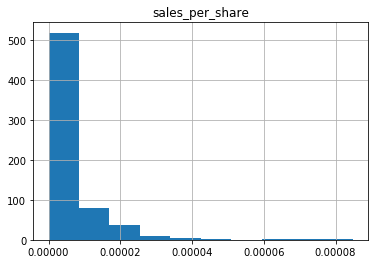

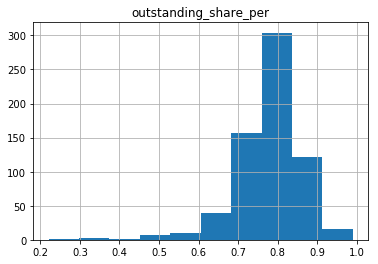

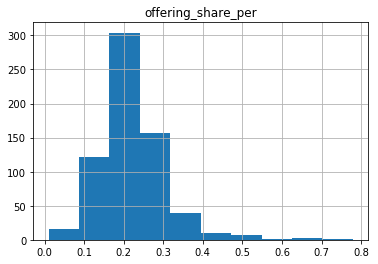

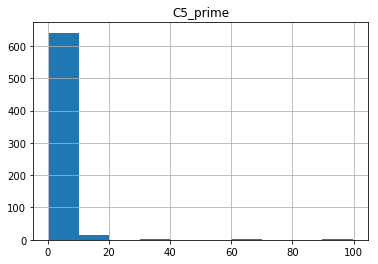

In [23]:
#For Loop created to view histograms of data
for i in bad_fields:
    conti[i].hist()
    plt.title(i)
    plt.show()

Start data normalizing transform techniques

In [25]:
norm = preprocessing.Normalizer()

In [26]:
norm_vals = norm.fit_transform(conti[bad_fields].values)
norm_vals = pd.DataFrame(norm_vals)
norm_vals.columns = bad_fields

In [27]:
norm_l2 = []
for i in norm_vals.columns:
    print(skew(norm_vals[i]))
    norm_l2.append(skew(norm_vals[i]))

3.6852597590330025
6.436211748354065
13.64984410482497
2.132744038500784
2.087368811843916
4.429300571372182
1.935435922093024
2.5838598818617062
2.1568488331041613
-10.242611937118271
5.8854689566526766
1.8302413997498381
3.0794496041512573
5.061315766965951


In [37]:
norm_2 = preprocessing.Normalizer(norm = 'l1')
norm_vals_2 = norm_2.fit_transform(conti[bad_fields].values)
norm_vals_2 = pd.DataFrame(norm_vals_2)
norm_vals_2.columns = bad_fields

norm_l1 = []
for i in norm_vals_2.columns:
    print(skew(norm_vals_2[i]))
    norm_l1.append(skew(norm_vals_2[i]))

3.6850336668882475
6.435409402617369
13.648768292468272
2.1326370296240067
2.087249966172831
4.429307911898792
1.9353460231079995
2.583724390602478
2.156749138820654
-3.287077580125796
5.885117883929834
1.8301398975912537
3.079321630418752
5.061394083932776


In [38]:
norm_2 = preprocessing.Normalizer(norm = 'l1')
norm_vals_2 = norm_2.fit_transform([conti['total_shares'].values])

In [39]:
norm_3 = preprocessing.Normalizer(norm = 'max')
norm_vals_3 = norm_3.fit_transform(conti[bad_fields].values)
norm_vals_3 = pd.DataFrame(norm_vals_3)
norm_vals_3.columns = bad_fields

norm_max = []
for i in norm_vals_3.columns:
    print(skew(norm_vals_3[i]))
    norm_max.append(skew(norm_vals_3[i]))  

3.6852597689136135
6.4362117828433805
13.649844200252286
2.1327440405964193
2.087368814276934
4.429300570906806
1.9354359238326
2.58385988492407
2.1568488349000283
0.0
5.885468970314219
1.8302414017734328
3.0794496066631396
5.061315765732395


In [40]:
norm_compare = pd.DataFrame()
norm_compare['field'] = bad_fields
norm_compare['orig'] = bad_skew
norm_compare['l2'] = norm_l2
norm_compare['l1'] = norm_l1
norm_compare['max'] = norm_max

In [41]:
norm_compare

,field,orig,l2,l1,max
0,C7_imputed,12.118756,3.685260,3.685034,3.685260
1,C1,5.645270,6.436212,6.435409,6.436212
2,C3_imputed,21.644949,13.649844,13.648768,13.649844
3,words_per_sentence,0.645238,2.132744,2.132637,2.132744
4,real_word_per,-11.914035,2.087369,2.087250,2.087369
5,non_real_word_per,11.914035,4.429301,4.429308,4.429301
6,short_sentences,1.922420,1.935436,1.935346,1.935436
7,short_sentences_per,1.587540,2.583860,2.583724,2.583860
8,long_sentences_per,-1.587540,2.156849,2.156749,2.156849
9,total_shares,13.272164,-10.242612,-3.287078,0.000000


# Yeo Johnson

Transform fields using the Yeo Johnson method for normalizing. The Yeo Johnson is an alternative to the Box-Cox power transform technique. It estimates the optimal value of lambda. The Yeo Johnson is similar to the Box-Cox, however it allows for the transformation of non-positive data. 

In [42]:
pwr_trs = preprocessing.power_transform(conti[bad_fields].values, method = 'yeo-johnson')

#pwr_trs = pwr_transform.fit_transform(conti[bad_fields].values)
pwr_trs = pd.DataFrame(pwr_trs)
pwr_trs.columns = bad_fields

pwr_norm = []
for i in pwr_trs.columns:
    #print(skew(pwr_trs[i]))
    pwr_norm.append(skew(pwr_trs[i]))

/opt/tljh/user/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [43]:
norm_compare['yeo_johnson'] = pwr_norm

In [44]:
norm_compare

,field,orig,l2,l1,max,yeo_johnson
0,C7_imputed,12.118756,3.685260,3.685034,3.685260,0.007101
1,C1,5.645270,6.436212,6.435409,6.436212,-0.026878
2,C3_imputed,21.644949,13.649844,13.648768,13.649844,0.681790
3,words_per_sentence,0.645238,2.132744,2.132637,2.132744,-0.003890
4,real_word_per,-11.914035,2.087369,2.087250,2.087369,-0.204923
5,non_real_word_per,11.914035,4.429301,4.429308,4.429301,0.003048
6,short_sentences,1.922420,1.935436,1.935346,1.935436,-0.000855
7,short_sentences_per,1.587540,2.583860,2.583724,2.583860,-0.073547
8,long_sentences_per,-1.587540,2.156849,2.156749,2.156849,0.109992
9,total_shares,13.272164,-10.242612,-3.287078,0.000000,0.000000


We notice that total_shares field, something has happened to make the max = 0. We can't have this and need to fix. Later we'll need to use the best value here so the l1 value of -3.287078 instead. 

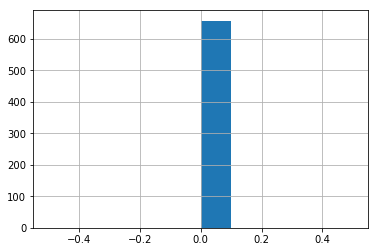

In [46]:
#Look at the total_shares field
pwr_trs['total_shares'].hist()
plt.show()

In [47]:
all_skew = pd.DataFrame()

In [48]:
pwr_transgorm_all = preprocessing.power_transform(conti[conti.columns[1:]].values, 
                                                  method = 'yeo-johnson')

pwr_transgorm_all = pd.DataFrame(pwr_transgorm_all)
pwr_transgorm_all.columns = conti.columns[:-1]

pwr_norm_all = []
for i in pwr_transgorm_all.columns:
    #print(skew(pwr_trs[i]))
    pwr_norm_all.append(skew(pwr_transgorm_all[i]))

/opt/tljh/user/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [49]:
normal_skew = skew(conti[conti.columns[1:]])

In [50]:
all_skew['yeo'] = pwr_norm_all
all_skew['orig'] = normal_skew

In [51]:
all_skew

,yeo,orig
0,0.007101,12.118756
1,-0.026878,5.645270
2,-0.006848,-0.474540
3,0.681790,21.644949
4,-0.003890,0.645238
5,-0.204923,-11.914035
6,0.003048,11.914035
7,-0.000855,1.922420
8,-0.073547,1.587540
9,0.109992,-1.587540


Everything here looks much better as it gets the values closer to 0. Now we need to fix field line 14 which is the total_shares column.

This made almost every one of them better so will use this for all...

Create the new data

In [52]:
pwr_transgorm_all = preprocessing.power_transform(conti[conti.columns[1:]].values, 
                                                  method = 'yeo-johnson')

/opt/tljh/user/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [53]:
pwr_transgorm_all = pd.DataFrame(pwr_transgorm_all)

In [54]:
pwr_transgorm_all.columns = conti.columns[1:]

In [55]:
pwr_transgorm_all['I1'] = conti['I1'].values

In [56]:
pwr_transgorm_all

,C7_imputed,C1,C4,C3_imputed,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime,I1
0,-0.435522,0.083556,0.625661,0.090772,0.041098,0.612727,-0.600033,0.131210,-0.098516,0.104980,0.282355,-0.134616,0.319442,-0.131815,0.0,-0.901218,0.079809,-0.075456,0.095989,0.809059,AATI
1,-0.804847,1.194205,-0.676024,0.047297,0.187881,0.108388,-0.086026,1.476971,-0.159445,0.166681,-0.102942,-1.459202,1.210623,-0.217787,0.0,-0.965298,2.322293,-2.338805,2.225766,-0.380114,ABPI
2,-1.436472,-0.374917,0.348750,0.051042,-0.235919,0.637715,-0.625810,-2.095431,-0.048186,0.053969,1.296397,2.876214,-1.889155,-0.791761,0.0,-1.162858,-0.236703,0.234711,-0.196085,-2.255397,ACAD
3,-1.368097,0.881342,0.326299,0.054241,-0.569181,1.064157,-1.070172,-0.167316,1.157431,-1.173915,1.278336,1.905052,-1.532951,-0.067201,0.0,-1.120476,-0.284734,0.281706,-0.240845,-1.034174,ACHN
4,1.017824,-0.553817,-1.245978,0.063359,-0.318098,-0.344652,0.365494,1.015483,0.598786,-0.604285,-0.486958,-0.515508,0.588919,-0.146732,0.0,1.658317,-0.004083,0.006856,0.018987,0.482042,ACLI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,0.293463,1.486274,-0.154037,0.059348,-0.674601,1.294081,-1.313241,0.681229,0.277588,-0.277001,-0.209906,0.620907,-0.748046,0.360780,0.0,0.016294,0.138336,-0.132935,0.149575,1.284717,ZIP
654,-0.814636,-0.246046,1.694689,0.058976,0.273820,0.475412,-0.458907,0.223660,-0.193850,0.201497,0.622589,-0.233011,-0.028931,0.307628,0.0,-1.039790,0.516487,-0.505666,0.494243,-0.499034,ZLTQ
655,-0.393276,-0.044796,0.671409,0.067985,0.042309,-0.297306,0.318760,-0.821352,-0.202167,0.209910,-0.564454,-0.399196,0.607066,-0.250225,0.0,-0.003881,-0.036973,0.039104,-0.011273,0.214481,ZSTN
656,0.030599,-0.592370,0.734814,0.064512,0.227300,0.640973,-0.629172,-2.059347,-1.176975,1.186528,-1.212307,0.955804,-2.049854,1.256821,0.0,0.737534,0.280647,-0.272912,0.279517,1.217828,ZUMZ


Now will handle the total_shares column seperately

In [59]:
pwr_transgorm_all['total_shares'] = norm_vals_2[0]

In [60]:
pwr_transgorm_all.columns = [i + '_normalized' for i in list(pwr_transgorm_all.columns)]

In [61]:
pwr_transgorm_all.to_csv('normalized_continuous_peter.csv')

In [62]:
print(pwr_transgorm_all.total_shares_normalized)

0      0.001251
1      0.000759
2      0.000530
3      0.000470
4      0.000946
         ...   
653    0.001167
654    0.000965
655    0.000354
656    0.000396
657    0.002881
Name: total_shares_normalized, Length: 658, dtype: float64
